### Goal
Normalize data and prepare the input/targets for the modeling  pairs of tissues (X,Y) per invidividual. 

### TODO
1. Data
    - 1.1 Subset to protein coding genes
    - 1.2 Sparsity of the data
2. Normalize data
    - 2.1 Determine the major transcript for the gene:
        - most coding exons, if not then:
        - if two transcripts same #coding_exons:
            - choose transcript with less non-coding exons
            - if equal: choose lowest ENS number
        - if no coding exons, then choose most #exons:
            - if equal: choose lowest ENS number
    - 2.2 Parse raw_counts to FPKM
    - 2.3 Parse raw_counts to TPM
    - 2.4 Compare TPM from recount2 to GTEx data

### Conclusions
1. Data
    - Data sparsity for gtex data, only protein-coding gene expression: 33%
2. Normalize data
    - Major transcript per gene can be found under `/s/project/rep/processed/annotation/gene_annotation_gencode.v25_hg38.json`
    - Decided to use TPM instead FPKM, because TPMs measure the relative expression abundance per sample (the mapped fragments sum up to 1Mb)
    - recount2 data has similar profile as displayed on GTEx portal.

In [10]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import h5py
import anndata

from rep import preprocessing_new as p

import warnings
warnings.simplefilter('ignore')

### 1. Data


In [36]:
os.getcwd()

data_dir = os.readlink("/s/project/rep")
print("data dir:", data_dir)
raw_data_dir = os.path.join(data_dir, "raw")
print("raw data dir:", raw_data_dir)
processed_data_dir = os.path.join(data_dir, "processed")
print("processed data dir:", processed_data_dir)

data dir: /data/ouga04b/ag_gagneur/project_local/rep
raw data dir: /data/ouga04b/ag_gagneur/project_local/rep/raw
processed data dir: /data/ouga04b/ag_gagneur/project_local/rep/processed


In [66]:
import pyranges as pr

# load annotation
gr = pr.read_gtf(os.path.join(raw_data_dir, "annotation", "gencode.v25.basic.annotation.gtf"))
gr

+--------------+------------+------------+-----------+-----------+------------+--------------+------------+------------+-------------------+---------------+-------------------------+-------------+---------------+-------+
| Chromosome   | Source     | Feature    | Start     | End       | Score      | Strand       | Frame      | ccdsid     | exon_id           | exon_number   | gene_id                 | gene_name   | gene_status   | ...   |
| (category)   | (object)   | (object)   | (int32)   | (int32)   | (object)   | (category)   | (object)   | (object)   | (object)          | (object)      | (object)                | (object)    | (object)      | ...   |
|--------------+------------+------------+-----------+-----------+------------+--------------+------------+------------+-------------------+---------------+-------------------------+-------------+---------------+-------|
| chr1         | HAVANA     | gene       | 11869     | 14409     | .          | +            | .          | nan     

#### 1.1 Filter summarized experiment by keeping only protein coding genes

In [158]:
# load gtex summarized experiment
file = os.path.join(processed_data_dir, "gtex", "recount", "recount_gtex.h5ad")
gtex = p.load(file)

In [148]:
gene_annot = gr.df
gene_annot = gene_annot[gene_annot.Feature == "gene"]
gene_annot = gene_annot.dropna(axis=1, how='all')
gene_annot.head()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_name,gene_status,gene_type,havana_gene,level,tag
0,chr1,HAVANA,gene,11869,14409,.,+,.,ENSG00000223972.5,DDX11L1,KNOWN,transcribed_unprocessed_pseudogene,OTTHUMG00000000961.2,2,NaN
28,chr1,HAVANA,gene,29554,31109,.,+,.,ENSG00000243485.4,MIR1302-2,KNOWN,lincRNA,OTTHUMG00000000959.2,2,NaN
41,chr1,HAVANA,gene,52473,53312,.,+,.,ENSG00000268020.3,OR4G4P,KNOWN,unprocessed_pseudogene,OTTHUMG00000185779.1,2,NaN
44,chr1,HAVANA,gene,62948,63887,.,+,.,ENSG00000240361.1,OR4G11P,KNOWN,unprocessed_pseudogene,OTTHUMG00000001095.2,2,NaN
47,chr1,HAVANA,gene,69091,70008,.,+,.,ENSG00000186092.4,OR4F5,KNOWN,protein_coding,OTTHUMG00000001094.2,2,NaN


In [159]:
# add annotation to gtex object
gtex.var = gtex.var.join(gene_annot.set_index("gene_id"), how="left")

# genes (columns) with no counts (zero expression) accross all samples (rows, tissues x invididuals)
gtex.var["not_is_all_zero"] = gtex.X.any(axis=0)

gtex.var.head()

,gene_id,bp_length,symbol,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_name,gene_status,gene_type,havana_gene,level,tag,not_is_all_zero
ENSG00000000003.14,ENSG00000000003.14,4535,TSPAN6,chrX,HAVANA,gene,100627109,100639991,.,-,.,TSPAN6,KNOWN,protein_coding,OTTHUMG00000022002.1,2,NaN,True
ENSG00000000005.5,ENSG00000000005.5,1610,TNMD,chrX,HAVANA,gene,100584802,100599885,.,+,.,TNMD,KNOWN,protein_coding,OTTHUMG00000022001.1,2,NaN,True
ENSG00000000419.12,ENSG00000000419.12,1207,DPM1,chr20,HAVANA,gene,50934867,50958555,.,-,.,DPM1,KNOWN,protein_coding,OTTHUMG00000032742.2,2,NaN,True
ENSG00000000457.13,ENSG00000000457.13,6883,SCYL3,chr1,HAVANA,gene,169849631,169894267,.,-,.,SCYL3,KNOWN,protein_coding,OTTHUMG00000035941.5,2,NaN,True
ENSG00000000460.16,ENSG00000000460.16,5967,C1orf112,chr1,HAVANA,gene,169662007,169854080,.,+,.,C1orf112,KNOWN,protein_coding,OTTHUMG00000035821.8,2,NaN,True


In [160]:
gtex.shape

(8911, 58037)

In [161]:
filtered_gtex = gtex[:, gtex.var["not_is_all_zero"] & (gtex.var["gene_type"] == "protein_coding")]

In [162]:
filtered_gtex.shape

(8911, 19932)

In [14]:
del gtex, zero_elem

In [15]:
repobj = p.RepAnnData(X=filtered_gtex.X, genes_var=filtered_gtex.var, samples_obs=filtered_gtex.obs)

In [16]:
repobj.save(os.path.join(processed_data_dir, "gtex", "recount", "recount_gtex_filtered.h5ad"))

'/data/ouga04b/ag_gagneur/project_local/rep/processed/gtex/recount/recount_gtex_filtered.h5ad'

#### 1.2 Sparsity of the data

In [32]:
# percent of zero values in X
1 - (np.count_nonzero(filtered_gtex.X) / np.size(filtered_gtex.X))

0.07651997039063108

### 2. Normalize data

#### 2.1 Determine the major transcript for the gene

In [34]:
# extract annotation for all genes
gene_annotation = p.get_annotation(os.path.join(raw_data_dir, "annotation", "gencode.v25.basic.annotation.gtf"))
p.writeJSON(gene_annotation, os.path.join(processed_data_dir, "annotation", "gene_annotation_gencode.v25_hg38.json"))

In [35]:
# check if the annotation is consistent between recount2 and gencode.v25
annotation_recount = repobj.genes.index.tolist()
for a in annotation_recount:
    if a not in gene_annotation:
        print("Annotation not found: ", a)

#### 2.2 Raw counts to FPKMs

Normalize data to FPKMs. (Counts of mapped fragments * 1000 * 1000) / (Length of transcript (kb) * Total Count of mapped fragments)

- Counts of mapped fragments = number of fragments mapped per sample
- Length of transcripts = choose per gene the transcript with most exons and get the length of the exonic regions (in kb)
- Total Count of mapped fragments = total counts per sample

In [20]:
# raw counts to FPKM
# (Counts of mapped fragments * 1000 * 1000) / (Length of transcript * Total Count of mapped fragments)
x_norm = p.raw_counts2fpkm(repobj, gene_annotation)
norm_gtex = p.RepAnnData(X=x_norm,samples_obs=repobj.samples,genes_var=repobj.genes)
norm_gtex.save(os.path.join(processed_data_dir, "gtex", "recount", "recount_gtex_norm_fpkm.h5ad"))

'/s/project/rep/processed/gtex/recount/recount_gtex_norm_fpkm.h5ad'

Plot correlation between raw matrix and normalized matrix

In [ ]:
sns.scatterplot(x=repobj.)

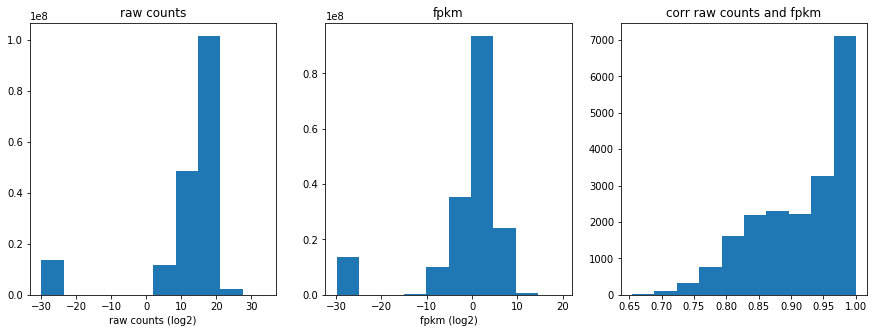

In [26]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)
plt.hist(np.asarray(np.log2(repobj.X.reshape(1, -1).squeeze() +  0.000000001)))
plt.title("raw counts")
plt.xlabel("raw counts (log2)")
# ax1.set_xscale('log', basex=2)
# plt.xlim(0,1024)

ax2 = fig.add_subplot(132)
plt.hist(np.log2(norm_gtex.X.reshape(1, -1).squeeze() + 0.000000001))
plt.title("fpkm")
plt.xlabel("fpkm (log2)")
# ax2.set_xscale('log', basex=2)
# plt.xlim(0,1024)

fig.add_subplot(133)
corr_values = pd.Series([stats.spearmanr(repobj.X[:, i], norm_gtex.X[:, i])[0]  for i in range(repobj.X.shape[1])])
plt.hist(corr_values.dropna())
plt.title("corr raw counts and fpkm")

plt.show()

#### 2.3. Raw counts to TPMs

Let $N_i$ be the number of reads coming from gene $i$ and $L_i$ be the length of gene $i$. 
$TPM_i = 10^6 * \frac{N_i / L_i} {\sum_j {N_j / L_j}}$

In [27]:
x_norm_tpm = p.raw_counts2tpm(repobj, gene_annotation)
norm_gtex_tpm = p.RepAnnData(X=x_norm_tpm,samples_obs=repobj.samples,genes_var=repobj.genes)
norm_gtex_tpm.save(os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_norm_tpm.h5ad"))

'/s/project/rep/processed/gtex/recount/recount_gtex_norm_tpm.h5ad'

Text(0.5, 0, 'tpm')

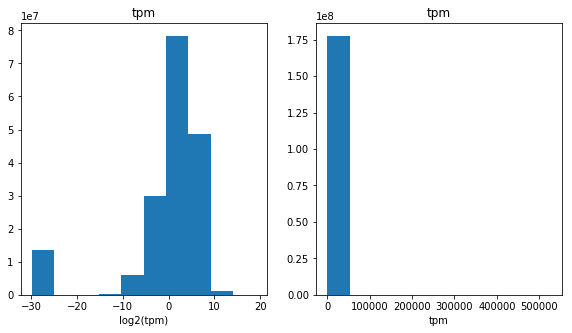

In [28]:
fig = plt.figure(figsize=(15,5))
ax1=fig.add_subplot(131)
plt.hist(np.log2(norm_gtex_tpm.X.reshape(1,-1).squeeze() +  0.000000001))
plt.title("tpm")
plt.xlabel("log2(tpm)")
ax1=fig.add_subplot(132)
plt.hist(norm_gtex_tpm.X.reshape(1,-1).squeeze() +  0.000000001)
plt.title("tpm")
plt.xlabel("tpm")

Compare the parsed data with GTEx data online for several genes

#### 2.4 Compare TPM from recount2 to GTEx data

We compare the TPM of gene = 'ENSG00000000003.14' between the GTEx Portal results and the recount2 data (after the in-house preprocessing step). This ensures that the data what we use and the computation of TPM are correct.

In [29]:
# rander svg img into jupyter-lab notebook
from IPython.display import SVG, display, Image
def show_img(path):
    extension = path.split(".")
    extension = extension[-1]
    if extension == 'svg': display(SVG(filename=path))
    else: 
        img = Image(path)
        display(img)

In [30]:
# list of tissues and parent tissues
tissues = sorted(list(set(norm_gtex_tpm.samples['Tissue'].tolist())))
parent_tissue = sorted(list(set(norm_gtex_tpm.samples['Parent_Tissue'].tolist())))

# generate colors
palette = sns.color_palette(None, len(parent_tissue)).as_hex()

In [31]:
# generate data
data = []

# PTEN "ENSG00000171862.9"
# TSPAN6 "ENSG00000000003.14"
# OPALIN - brain enriched ENSG00000197430.10
# TTN - muscles enriched ENSG00000155657.25 - hier they cut at 1200 (removed an outlier with TPM=8000 ish)
gene = 'ENSG00000000003.14'
gtex_tmp = norm_gtex_tpm[:,gene] # after filtering this is converted to AnnData
for t in tissues:
    pt = list(set(gtex_tmp[gtex_tmp.obs['Tissue'] == t].obs['Parent_Tissue'].tolist()))[0]
    color_pt = palette[parent_tissue.index(pt)]
    data.append(graph_objs.Box(y=gtex_tmp[norm_gtex_tpm.obs['Tissue'] == t].X, 
                                name=t,
                                fillcolor= color_pt,
                                marker = dict(
                                    color = color_pt)))

NameError: name 'graph_objs' is not defined

In [ ]:
# plot figure
fig = graph_objs.Figure(data=data, layout=po.get_layout(_xlab='Tissues',_ylab='TPM',_title= "recount2 - Expression of " + gene))
py.iplot(fig, filename='tpm_per_tissue_' + gene)

In [ ]:
show_img('2_normalize_gtex_files/tpm_ENSG00000000003.png')

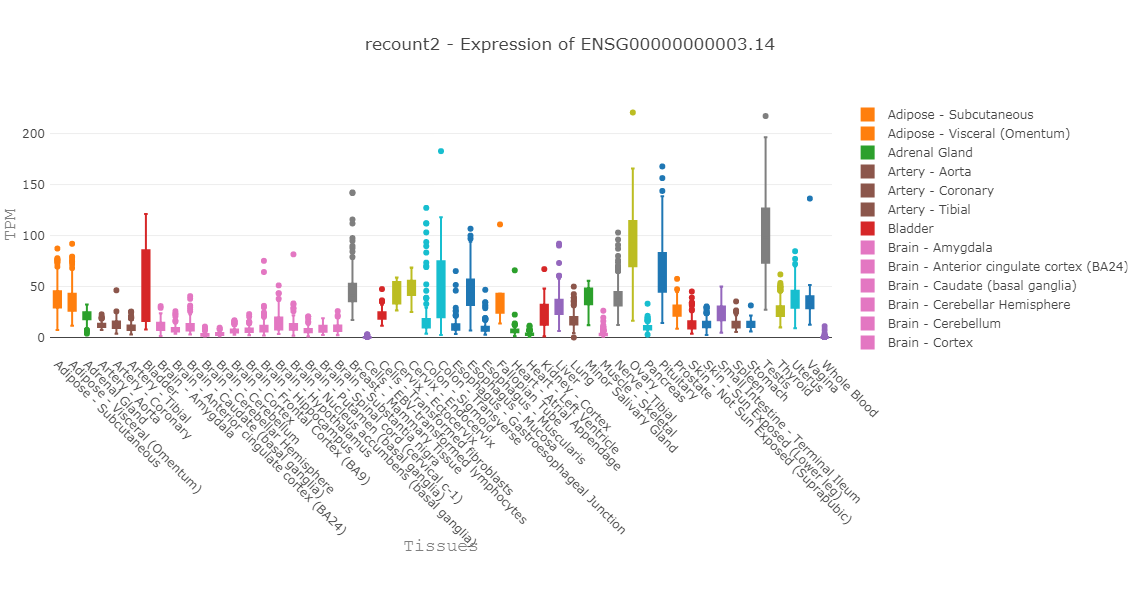

In [49]:
show_img('2_normalize_gtex_files/2_normalize_gtex_25_0.png')